In [1]:
using Images, TestImages, BenchmarkTools, ImageQualityIndexes, ImageBinarization

┌ Info: Recompiling stale cache file /Users/jc/.julia/compiled/v1.2/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jc/.julia/compiled/v1.2/ImageQualityIndexes/r7w33.ji for ImageQualityIndexes [2996bd0c-7a13-11e9-2da2-2f5ce47296a9]
└ @ Base loading.jl:1240


# Part II: JuliaImages 在做什么

## 1.1 统一图像类型

### 1.1.1 现状

关于图像，我们有...

* `UInt8`: {0, 1, ..., 255}
* `UInt16`: {0, 1, ..., 65535}
* `Float32`: [0. -1.]
* `Float64`: [0., 1.]

关于色彩，我们有...

* 灰度图 `Gray`
* 彩色`RGB`
* 彩色`Lab`
* 彩色`HSV`

关于图像的维度，我们还有...

* 时间
* WHCB vs BCWH (Batch, Channel, Width, Height)

图像的表示方式又有...

* 矩阵
* 点云

这种现象就导致了... 对于一个尺寸为`(256, 128, 3)`的矩阵，有如下解释：

* 一个宽高深为（256, 128, 3)的3D灰度图 or Gray MRI images
* 一个宽高为(256, 128)的彩色RGB图片
* 一个宽高为(256, 128)的彩色Lab图片
* 一个宽高为(256, 128)的三帧图片

在使用Matlab Image Processing Toolbox, Python scikit-images, OpenCV的过程中，我们一般都是将图像转换/解释为RGB图像。


图像究竟是什么是由我们来解释的

In [2]:
img = rand(3, 3, 3)

3×3×3 Array{Float64,3}:
[:, :, 1] =
 0.680456  0.87894   0.498237
 0.167882  0.465608  0.725763
 0.874397  0.181259  0.708058

[:, :, 2] =
 0.845273  0.274575  0.842656
 0.269204  0.984254  0.951895
 0.398728  0.570891  0.600963

[:, :, 3] =
 0.94368   0.775177  0.368404
 0.873057  0.244958  0.760128
 0.508583  0.703861  0.953323

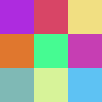

In [3]:
colorview(RGB, img)

In [4]:
typeof(ans)

Base.ReshapedArray{RGB{Float64},2,Base.ReinterpretArray{RGB{Float64},3,Float64,Array{Float64,3}},Tuple{}}

In [5]:
colorview(Lab, img) |> typeof

Base.ReshapedArray{Lab{Float64},2,Base.ReinterpretArray{Lab{Float64},3,Float64,Array{Float64,3}},Tuple{}}

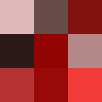

In [6]:
colorview(HSV, img)

In [7]:
colorview(Gray, img)

3×3×3 reinterpret(Gray{Float64}, ::Array{Float64,3}):
[:, :, 1] =
 Gray{Float64}(0.680456)  Gray{Float64}(0.87894)   Gray{Float64}(0.498237)
 Gray{Float64}(0.167882)  Gray{Float64}(0.465608)  Gray{Float64}(0.725763)
 Gray{Float64}(0.874397)  Gray{Float64}(0.181259)  Gray{Float64}(0.708058)

[:, :, 2] =
 Gray{Float64}(0.845273)  Gray{Float64}(0.274575)  Gray{Float64}(0.842656)
 Gray{Float64}(0.269204)  Gray{Float64}(0.984254)  Gray{Float64}(0.951895)
 Gray{Float64}(0.398728)  Gray{Float64}(0.570891)  Gray{Float64}(0.600963)

[:, :, 3] =
 Gray{Float64}(0.94368)   Gray{Float64}(0.775177)  Gray{Float64}(0.368404)
 Gray{Float64}(0.873057)  Gray{Float64}(0.244958)  Gray{Float64}(0.760128)
 Gray{Float64}(0.508583)  Gray{Float64}(0.703861)  Gray{Float64}(0.953323)

### 1.1.2. 问题

* 如何保证这种解释的统一性

* 如何与其他的图像类型进行互操作

* 如何协调非标准库 (Non-JuliaImages)

### 1.1.2 JuliaImages的决定

> 矩阵元素即像素

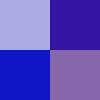

In [8]:
img = rand(RGB, 2, 2)

In [9]:
eltype(ans)

RGB{Float64}

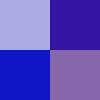

In [10]:
HSV.(img)

In [11]:
eltype(ans)

HSV{Float64}

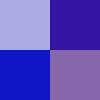

In [12]:
Lab.(img)

In [13]:
eltype(ans)

Lab{Float64}

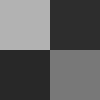

In [14]:
Gray.(img)

In [15]:
eltype(ans)

Gray{Float64}

In [16]:
img = rand(Gray, 3, 3, 3)

3×3×3 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.200295)  Gray{Float64}(0.742935)  Gray{Float64}(0.100768) 
 Gray{Float64}(0.455829)  Gray{Float64}(0.2204)    Gray{Float64}(0.033329) 
 Gray{Float64}(0.179783)  Gray{Float64}(0.444437)  Gray{Float64}(0.0497722)

[:, :, 2] =
 Gray{Float64}(0.122299)  Gray{Float64}(0.524446)  Gray{Float64}(0.129994)
 Gray{Float64}(0.982783)  Gray{Float64}(0.131367)  Gray{Float64}(0.408896)
 Gray{Float64}(0.667697)  Gray{Float64}(0.130427)  Gray{Float64}(0.128194)

[:, :, 3] =
 Gray{Float64}(0.014261)  Gray{Float64}(0.835086)  Gray{Float64}(0.726078)
 Gray{Float64}(0.133558)  Gray{Float64}(0.122035)  Gray{Float64}(0.547624)
 Gray{Float64}(0.447273)  Gray{Float64}(0.863369)  Gray{Float64}(0.067862)

In [17]:
AxisArray(img, :width, :height, :depth)

3-dimensional AxisArray{Gray{Float64},3,...} with axes:
    :width, Base.OneTo(3)
    :height, Base.OneTo(3)
    :depth, Base.OneTo(3)
And data, a 3×3×3 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.200295)  Gray{Float64}(0.742935)  Gray{Float64}(0.100768) 
 Gray{Float64}(0.455829)  Gray{Float64}(0.2204)    Gray{Float64}(0.033329) 
 Gray{Float64}(0.179783)  Gray{Float64}(0.444437)  Gray{Float64}(0.0497722)

[:, :, 2] =
 Gray{Float64}(0.122299)  Gray{Float64}(0.524446)  Gray{Float64}(0.129994)
 Gray{Float64}(0.982783)  Gray{Float64}(0.131367)  Gray{Float64}(0.408896)
 Gray{Float64}(0.667697)  Gray{Float64}(0.130427)  Gray{Float64}(0.128194)

[:, :, 3] =
 Gray{Float64}(0.014261)  Gray{Float64}(0.835086)  Gray{Float64}(0.726078)
 Gray{Float64}(0.133558)  Gray{Float64}(0.122035)  Gray{Float64}(0.547624)
 Gray{Float64}(0.447273)  Gray{Float64}(0.863369)  Gray{Float64}(0.067862)

In [18]:
AxisArray(img, :width, :height, :frame)

3-dimensional AxisArray{Gray{Float64},3,...} with axes:
    :width, Base.OneTo(3)
    :height, Base.OneTo(3)
    :frame, Base.OneTo(3)
And data, a 3×3×3 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.200295)  Gray{Float64}(0.742935)  Gray{Float64}(0.100768) 
 Gray{Float64}(0.455829)  Gray{Float64}(0.2204)    Gray{Float64}(0.033329) 
 Gray{Float64}(0.179783)  Gray{Float64}(0.444437)  Gray{Float64}(0.0497722)

[:, :, 2] =
 Gray{Float64}(0.122299)  Gray{Float64}(0.524446)  Gray{Float64}(0.129994)
 Gray{Float64}(0.982783)  Gray{Float64}(0.131367)  Gray{Float64}(0.408896)
 Gray{Float64}(0.667697)  Gray{Float64}(0.130427)  Gray{Float64}(0.128194)

[:, :, 3] =
 Gray{Float64}(0.014261)  Gray{Float64}(0.835086)  Gray{Float64}(0.726078)
 Gray{Float64}(0.133558)  Gray{Float64}(0.122035)  Gray{Float64}(0.547624)
 Gray{Float64}(0.447273)  Gray{Float64}(0.863369)  Gray{Float64}(0.067862)

In [19]:
AxisArray(img, :width, :height, :time)

3-dimensional AxisArray{Gray{Float64},3,...} with axes:
    :width, Base.OneTo(3)
    :height, Base.OneTo(3)
    :time, Base.OneTo(3)
And data, a 3×3×3 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.200295)  Gray{Float64}(0.742935)  Gray{Float64}(0.100768) 
 Gray{Float64}(0.455829)  Gray{Float64}(0.2204)    Gray{Float64}(0.033329) 
 Gray{Float64}(0.179783)  Gray{Float64}(0.444437)  Gray{Float64}(0.0497722)

[:, :, 2] =
 Gray{Float64}(0.122299)  Gray{Float64}(0.524446)  Gray{Float64}(0.129994)
 Gray{Float64}(0.982783)  Gray{Float64}(0.131367)  Gray{Float64}(0.408896)
 Gray{Float64}(0.667697)  Gray{Float64}(0.130427)  Gray{Float64}(0.128194)

[:, :, 3] =
 Gray{Float64}(0.014261)  Gray{Float64}(0.835086)  Gray{Float64}(0.726078)
 Gray{Float64}(0.133558)  Gray{Float64}(0.122035)  Gray{Float64}(0.547624)
 Gray{Float64}(0.447273)  Gray{Float64}(0.863369)  Gray{Float64}(0.067862)

In [20]:
AxisArray(img, :width, :height, :slice)

3-dimensional AxisArray{Gray{Float64},3,...} with axes:
    :width, Base.OneTo(3)
    :height, Base.OneTo(3)
    :slice, Base.OneTo(3)
And data, a 3×3×3 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.200295)  Gray{Float64}(0.742935)  Gray{Float64}(0.100768) 
 Gray{Float64}(0.455829)  Gray{Float64}(0.2204)    Gray{Float64}(0.033329) 
 Gray{Float64}(0.179783)  Gray{Float64}(0.444437)  Gray{Float64}(0.0497722)

[:, :, 2] =
 Gray{Float64}(0.122299)  Gray{Float64}(0.524446)  Gray{Float64}(0.129994)
 Gray{Float64}(0.982783)  Gray{Float64}(0.131367)  Gray{Float64}(0.408896)
 Gray{Float64}(0.667697)  Gray{Float64}(0.130427)  Gray{Float64}(0.128194)

[:, :, 3] =
 Gray{Float64}(0.014261)  Gray{Float64}(0.835086)  Gray{Float64}(0.726078)
 Gray{Float64}(0.133558)  Gray{Float64}(0.122035)  Gray{Float64}(0.547624)
 Gray{Float64}(0.447273)  Gray{Float64}(0.863369)  Gray{Float64}(0.067862)

## 1.2 统一算法框架

### 1.2.1 现状

* 图像处理工具箱很大程度上就是算法的集合
* 算法与API的耦合过于紧密

* `psnr(src_img, ref_img, peak_val)`

* `foo(src_img, ref_img, peak_val)`

* `foo(x, y, args...)`

### 1.2.2 JuliaImages 的决定

* 每一个算法都是一个具体的结构struct
* 每一个算法特定的信息都存储在该结构中

For example:

```julia
denoise([T::Type,] src_img, alg::DenoisingAlgorithm)
denoise!(out, src_img, alg::DenoisingALgorithm)
```

In [21]:
src_img = testimage("cameraman");
ref_img = testimage("lena_gray_512");

In [22]:
psnr(src_img, ref_img) # usage 1

11.103267f0

In [23]:
index = PSNR()
assess(index, src_img, ref_img) # usage 2

11.103267f0

In [24]:
index(src_img, ref_img) # usage 3

11.103267f0

#### 1.2.2.1 接口设计

In [25]:
abstract type ImageAlgorithm end
abstract type ImageDenoisingFilter <: ImageAlgorithm end

function imdenoise(::Type{T},
                   src::AbstractArray,
                   alg::ImageDenoisingFilter) where T
    out = Array{T}(undef, size(src))
    alg(out, src)
end
function imdenoise(src::AbstractArray,
                   alg::ImageDenoisingFilter)
    imdenoise(eltype(src), src, alg)
end

imdenoise (generic function with 2 methods)

#### 1.2.2.2 实现设计

In [26]:
""" Dummy image denoiser that does nothing"""
struct DummyDenoiser <: ImageDenoisingFilter
    repeat
end

function (alg::DummyDenoiser)(out, src)
    for i in range(1, stop=alg.repeat)
        println("Iter $(i): Okay, got src denoised :D")
    end
    out .= src
end

In [27]:
alg = DummyDenoiser(5)
imdenoise(rand(3, 3), alg)

Iter 1: Okay, got src denoised :D
Iter 2: Okay, got src denoised :D
Iter 3: Okay, got src denoised :D
Iter 4: Okay, got src denoised :D
Iter 5: Okay, got src denoised :D


3×3 Array{Float64,2}:
 0.847528  0.0665198  0.760806
 0.821276  0.105887   0.603834
 0.995517  0.808367   0.502265

每一次调用算法都需要重建一个新的算法实例 -- 对于non-trivial算法而言，这个开销是可接受的

已经采用这种设计的库：

* 二值化算法库 `ImageBinarization.jl`: https://github.com/zygmuntszpak/ImageBinarization.jl
* 图像质量评价 `ImageQualityIndexes.jl`: https://github.com/JuliaImages/ImageQualityIndexes.jl

关于该设计的一篇博客：https://nextjournal.com/johnnychen94/the-principles-of-imagesjl-part-i

## JuliaImages 总结

接下来：

- [x] 底层设计
- [ ] 统一API接口 (统一计算设备)
- [ ] 填充算法库
- [ ] Tutorials/Demos
- [ ] Benchmarking
- [ ] 载入加速
- [ ] OpenCV wrapper
- [ ] GUI

Nice to have:

* 整合Flux.jl